## Dependencies

In [6]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Loading The Model

In [9]:
interpreter = tf.lite.Interpreter(model_path='./models_lite/resnet_lite_1.tflite')
interpreter.allocate_tensors()
print('Model Loaded Sucessfully!')

Model Loaded Sucessfully!


In [11]:
path = './lpd_dataset_v2/lpd_image (1).jpg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224,3))
image_arr_224 = img_to_array(image1)/255.0 # convert into array and get the normalized output

In [20]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 832,
  'shape': array([1, 4]),
  'shape_signature': array([-1,  4]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [12]:
# print size of the original image
h,w,d = image.shape
print("Image Height =",h)
print("Image Width =",w)

Image Height = 225
Image Width = 225


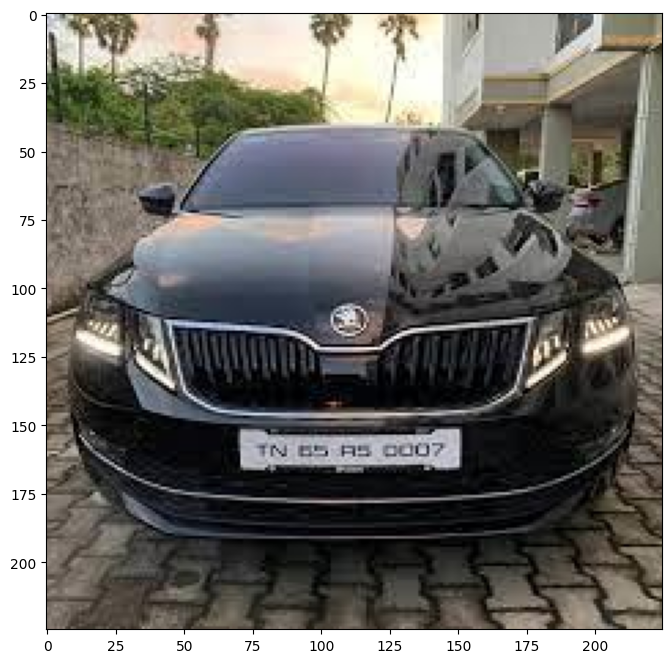

In [13]:
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [14]:
image_arr_224.shape

(224, 224, 3)

In [15]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [21]:
# Perform inference
interpreter.set_tensor(input_details[0]['index'], test_arr)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [22]:
# Denormalize the values
denorm = np.array([w, w, h, h])
coords = output_data * denorm
coords = coords.astype(np.int32)

In [23]:
# Drawing a bounding box on top of the image
xmin, xmax, ymin, ymax = coords[0]
pt1 = (xmin, ymin)
pt2 = (xmax, ymax)
print(pt1, pt2)

(0, 137) (225, 225)


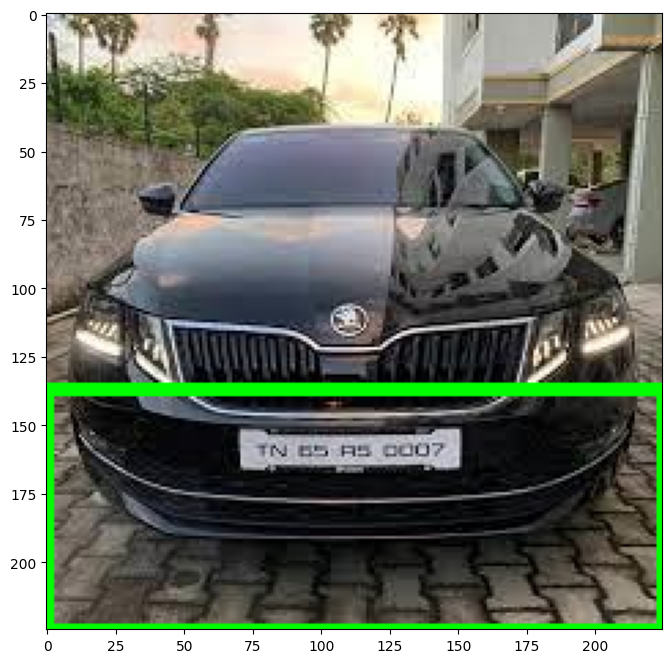

In [25]:
image_path = './lpd_dataset_v2/lpd_image (1).jpg'
image = cv2.imread(image_path)

# Drawing a bounding box on top of the image
cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)

# Display the image with bounding box
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.show()

## Creating A Pipeline

In [29]:
def object_detection(path):
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224,3))
    image_arr_224 = img_to_array(image1)/255.0 # convert into array and get the normalized output
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    # Perform inference
    interpreter.set_tensor(input_details[0]['index'], test_arr)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # Denormalize the values
    denorm = np.array([w, w, h, h])
    coords = output_data * denorm
    coords = coords.astype(np.int32)
    # Drawing a bounding box on top of the image
    xmin, xmax, ymin, ymax = coords[0]
    pt1 = (xmin, ymin)
    pt2 = (xmax, ymax)
    cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)
    return image, coords

In [30]:
# Call the object_detection function
test_image = './lpd_dataset_v2/lpd_image (1).jpg'
image_with_bbox, _ = object_detection(test_image)

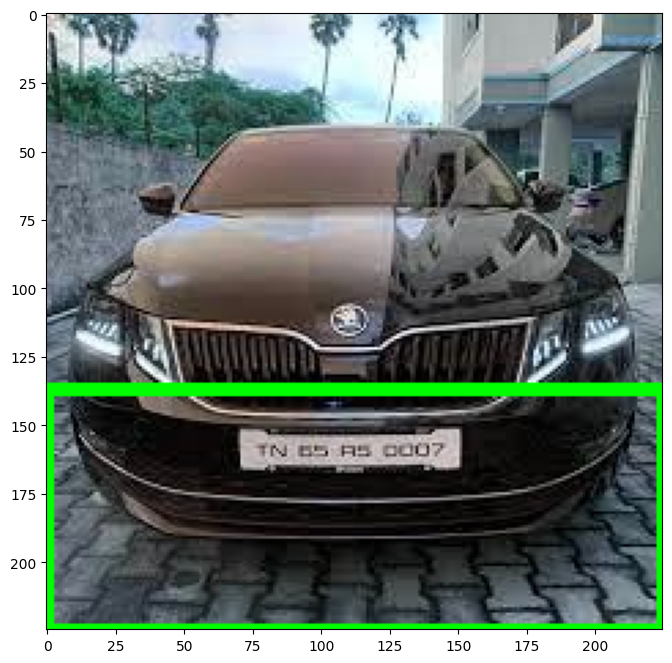

In [32]:
# Display the image with bounding box
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.show()

## Using Webcam

In [34]:
import cv2
import numpy as np

def object_detection_webcam(interpreter, input_details, output_details):
    # Open a connection to the webcam
    cap = cv2.VideoCapture(0)  # 0 for the default webcam, change if you have multiple cameras

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Resize frame to match the input size of the model
        resized_frame = cv2.resize(frame, (224, 224))

        # Convert frame to RGB (OpenCV captures in BGR)
        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

        # Convert frame to float and normalize
        image_arr_224 = rgb_frame.astype(np.float32) / 255.0

        # Expand dimensions to match the expected input shape of the model
        test_arr = np.expand_dims(image_arr_224, axis=0)

        # Perform inference
        interpreter.set_tensor(input_details[0]['index'], test_arr)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Denormalize the values
        denorm = np.array([resized_frame.shape[1], resized_frame.shape[1], resized_frame.shape[0], resized_frame.shape[0]])
        coords = output_data * denorm
        coords = coords.astype(np.int32)

        # Drawing bounding boxes
        xmin, xmax, ymin, ymax = coords[0]
        pt1 = (xmin, ymin)
        pt2 = (xmax, ymax)
        cv2.rectangle(frame, pt1, pt2, (0, 255, 0), 3)

        # Display the frame with bounding box
        cv2.imshow('Object Detection', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the capture
    cap.release()
    cv2.destroyAllWindows()

# Call the object_detection_webcam function
object_detection_webcam(interpreter, input_details, output_details)

# Optical Character Recognition

In [1]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [14]:
test_image = './lpd_dataset_v2/lpd_image (486).jpg'

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(test_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


## Draw Results

In [ ]:
top_left = tuple(result[0][0][0])
bottom_right = tuple(result[0][0][2])
text = result[0][1]
font = cv2.FONT_HERSHEY_SIMPLEX

In [ ]:
img = cv2.imread(test_image)
img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
img = cv2.putText(img,text,top_left, font, 0.5,(255,255,255),2,cv2.LINE_AA)
plt.imshow(img)
plt.show()